# Logistic Regression Model
## 281 - Computer Vision
### German Traffic Sign Classification

### Lisa Wu  -   Ed Brown   -   Alejandro Reskala

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd

from io import BytesIO
from pathlib import Path
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

from feature_utils import normalize_histogram
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import time
import datetime
import warnings
warnings.filterwarnings('ignore')


2023-12-12 20:44:46.934421: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_path = './sign_data/'
use_split_test = False

**Load parquet files and create polar data frames**

In [3]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path(dataset_path + "data/train_features.parquet")
test_file = Path(dataset_path + "data/test_features.parquet")
meta_file = Path(dataset_path + "data/meta_full.parquet")

dft = pl.read_parquet(features_file, memory_map=True)
dfe = pl.read_parquet(test_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)

dft = dft.join(dfm, on="ClassId")
dfe = dfe.join(dfm, on="ClassId")

del dfm

In [4]:
# Select 200 images per class
samples_per_class = 200
random_seed = 42
features = pl.concat([x.sample(samples_per_class, with_replacement=False, seed=random_seed) for x in dft.partition_by("ClassId")])


In [5]:
dfe.head(1)
# Test distribution:
# features.groupby("ClassId").agg(pl.count())


id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,16,64,64,[binary data],4096,[binary data],"[63, 58, … 113]","[0, 0, … 0]","[0, 0, … 0]",[binary data],"[195, 142, … 0]","[0.119428, 0.135571, … 0.005196]",[binary data],"[0.097359, 0.076541, … 0.101359]","[0.867967, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""/work/06333/ed…",1,0,"""3.3""","""Over 3.5 Tons …",[binary data],100,100,10000,64,64,[binary data],4096


In [6]:
columns = [
           'ClassId', 'Hue_Hist', 'Saturation_Hist', 'HOG_Features',
           'Template_Pattern', 'RESNET101', 'VGG16', 'LBP_Image'
          ]
features = features[columns]
features.head(1)


ClassId,Hue_Hist,Saturation_Hist,HOG_Features,Template_Pattern,RESNET101,VGG16,LBP_Image
i64,list[i64],list[i64],list[f32],list[f32],list[f64],list[f64],binary
20,"[972, 151, … 16]","[247, 0, … 0]","[0.25923, 0.184951, … 0.0]","[0.245245, 0.24306, … 0.12408]","[0.812232, 0.0, … 0.0]","[0.0, 0.0, … 0.0]",[binary data]


In [7]:
test_features = dfe[columns]
test_features.head(1)


ClassId,Hue_Hist,Saturation_Hist,HOG_Features,Template_Pattern,RESNET101,VGG16,LBP_Image
i64,list[i64],list[i64],list[f32],list[f32],list[f64],list[f64],binary
16,"[63, 58, … 113]","[0, 0, … 0]","[0.119428, 0.135571, … 0.005196]","[0.097359, 0.076541, … 0.101359]","[0.867967, 0.0, … 0.0]","[0.0, 0.0, … 0.0]",[binary data]


In [8]:
del dft
del dfe


### Logistic Regression Model

In [9]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.model_fit_time = time.time()
        
    def on_train_end(self, logs={}):
        self.model_fit_time = time.time() - self.model_fit_time

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [10]:
# List where all features models will be stored
modelos = []

In [11]:
def build_model(num_features, learning_rate=.001):
    """Build a TF linear regression model using Keras.

    Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # Setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(
        units=43,                     # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
        activation='softmax'
    ))
    
    # We'll use SGD
    # We will specify the batch size to use for training later.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Finally, we compile the model. This finalizes the graph for training.
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model

In [12]:
def plot_loss(history, title):
    """Plot the loss after each training epoch."""
    # Convert the history object into a DataFrame.
    history = pd.DataFrame(history.history)   
    history = history[np.isfinite(history).all(1)]

    plt.suptitle("Models", fontsize=16, color="black", fontweight="bold")
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(history)), history['loss'], marker='.', color='black')
    plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.title(title)
    plt.show()

    # Show the final train loss value and the learned model weights.
    print('Final train loss:', list(history['loss'])[-1])



In [13]:
# Create a confusion matrix as a 2D array.
def plot_confusion_matrix(title, y_test, y_prediction):
    label_names = [f"Class {i}" for i in range(43)]

    confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(12, 10))

    color_map1 = ['lightgrey', '#ffff99', 'orange', '#7fc97f']
    color_map = ListedColormap(color_map1)

    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap=color_map,
        linewidths=0.5,
        square=True,
        cbar_kws={"label": "Count"},
        xticklabels=label_names,
        yticklabels=label_names,
        annot_kws={"size": 10},
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(title + " Confusion Matrix", fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=80, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Adjust layout to prevent cutoff of labels
    plt.tight_layout()

    # Add axis labels.
    # ax.set(xlabel="Predicted Label", ylabel="True Label")
    plt.show()
    return

In [14]:
def format_time(seconds=0, mili=False):
    elapsed = str(datetime.timedelta(seconds=seconds))
    point = elapsed.find('.')
    if point > 0:
        if mili is False:
            elapsed = elapsed[:point]
        else:
            elapsed = elapsed[point-1:]
    return elapsed


<HR>

### HOG Features

In [15]:
# Derive HOG dataset

features_hog = features['HOG_Features'].to_numpy()
features_hog = np.stack(features_hog)

if use_split_test is True:
    # split the data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(features_hog, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)
else:
    X_train = features['HOG_Features'].to_numpy()
    X_train = np.stack(X_train)
    y_train = features['ClassId'].to_numpy()

    X_test = test_features['HOG_Features'].to_numpy()
    X_test = np.stack(X_test)
    y_test = test_features['ClassId'].to_numpy()


In [16]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (8600, 2916)
y_train.shape: (8600,)
X_test.shape: (12630, 2916)
y_test.shape: (12630,)


In [17]:
num_features = X_train.shape[1]
learningRate = 0.1
model = build_model(num_features, learningRate)
# print(model.summary())

time_callback = TimeHistory()
history = model.fit(x=X_train, y=y_train, epochs=300, verbose=0, validation_split=0.2, batch_size=50,
                    callbacks=[time_callback])

print('Overall elapsed time:', time_callback.model_fit_time)

# Log metrics
modelo = ['HOG']
modelo.append(history)


Overall elapsed time: 66.66856098175049


In [18]:
# Make predictions on test data using HOG Features
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# results = model.evaluate(X_test, y_test, batch_size=32)
# print("test loss, test acc:", results)

test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=32)
print("test loss, test acc:", test_loss)

test_rmse = np.sqrt(test_loss)
print('Test rmse:', test_rmse)


# Predict
y_pred = model.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

Evaluate on test data
test loss, test acc: [1.7343155145645142, 0.8038004636764526]
Test rmse: [1.31693413 0.8965492 ]
395/395 [==============================] - 0s 744us/step

Accuracy on Test Set: 80.38004750593825


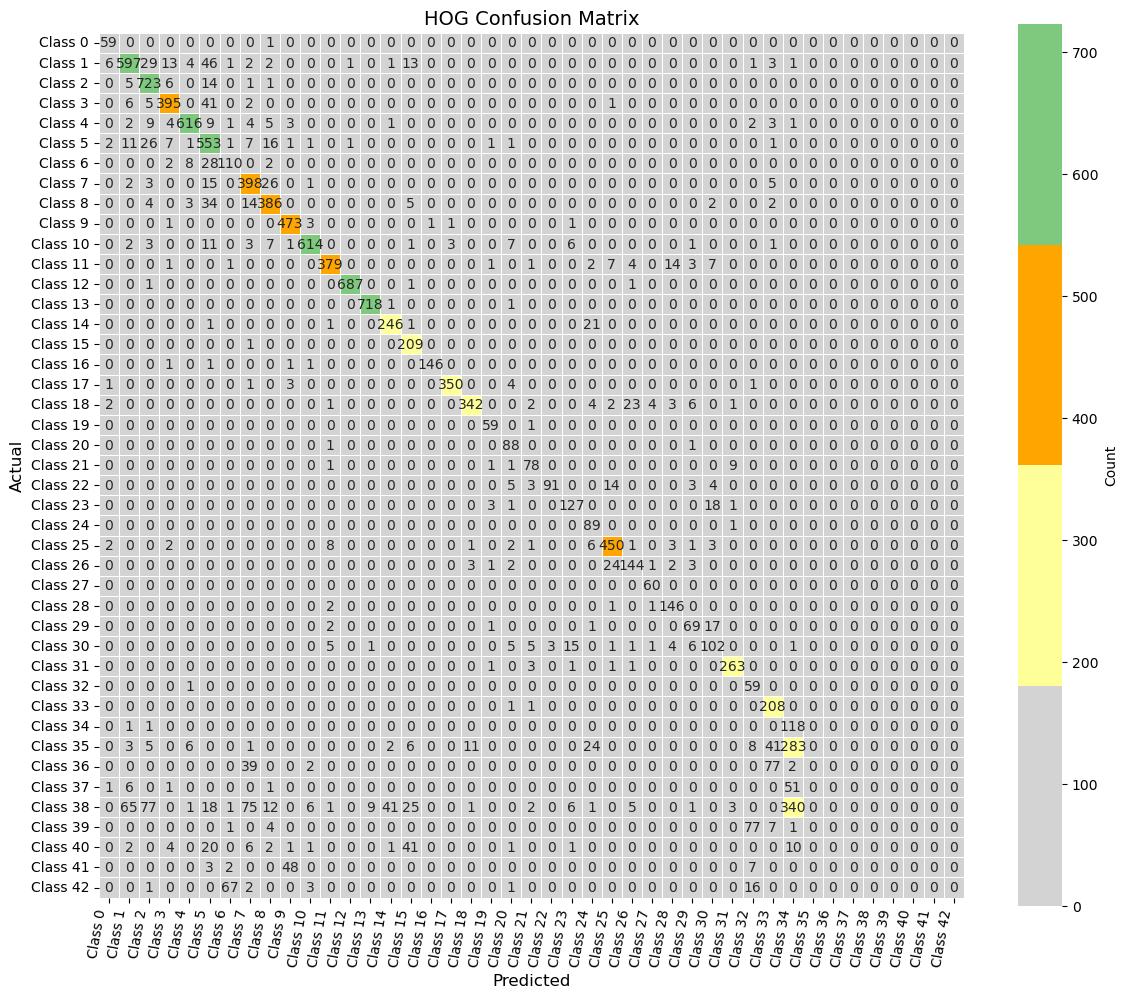

In [19]:
plot_confusion_matrix('HOG', y_test, y_prediction)

In [20]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_prediction, average='weighted')
print('Model Precision:', precision)
print('Model Recall:', recall)
print('Model F-1 score:', fscore)
modelo.append(precision)
modelo.append(recall)
modelo.append(fscore)
modelo.append(format_time(time_callback.model_fit_time))

modelos.append(modelo)

Model Precision: 0.7501665187005869
Model Recall: 0.8038004750593825
Model F-1 score: 0.7697583544480976


<HR>

### Template Match Features

In [21]:
# Derive Template dataset

features_tem = features['Template_Pattern'].to_numpy()
features_tem = np.stack(features_tem)

if use_split_test is True:
    # split the data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(features_tem, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)
else:
    X_train = features['Template_Pattern'].to_numpy()
    X_train = np.stack(X_train)
    y_train = features['ClassId'].to_numpy()

    X_test = test_features['Template_Pattern'].to_numpy()
    X_test = np.stack(X_test)
    y_test = test_features['ClassId'].to_numpy()


In [22]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (8600, 3483)
y_train.shape: (8600,)
X_test.shape: (12630, 3483)
y_test.shape: (12630,)


In [23]:
num_features = X_train.shape[1]
learningRate = 0.01
model = build_model(num_features, learningRate)
# print(model.summary())

time_callback = TimeHistory()
history = model.fit(x=X_train, y=y_train, epochs=3500, verbose=0, validation_split=0.2, batch_size=32,
                    callbacks=[time_callback])

print('Overall elapsed time:', time_callback.model_fit_time)

# Log metrics
modelo = ['Template']
modelo.append(history)


Overall elapsed time: 4814.375448942184


In [24]:
# Make predictions on test data using Template Matching Features
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# results = model.evaluate(X_test, y_test, batch_size=32)
# print("test loss, test acc:", results)

test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=32)
print("test loss, test acc:", test_loss)

test_rmse = np.sqrt(test_loss)
print('Test rmse:', test_rmse)


# Predict
y_pred = model.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

Evaluate on test data
test loss, test acc: [3.0604491233825684, 0.7250198125839233]
Test rmse: [1.74941394 0.85148095]
395/395 [==============================] - 0s 771us/step

Accuracy on Test Set: 72.50197941409343


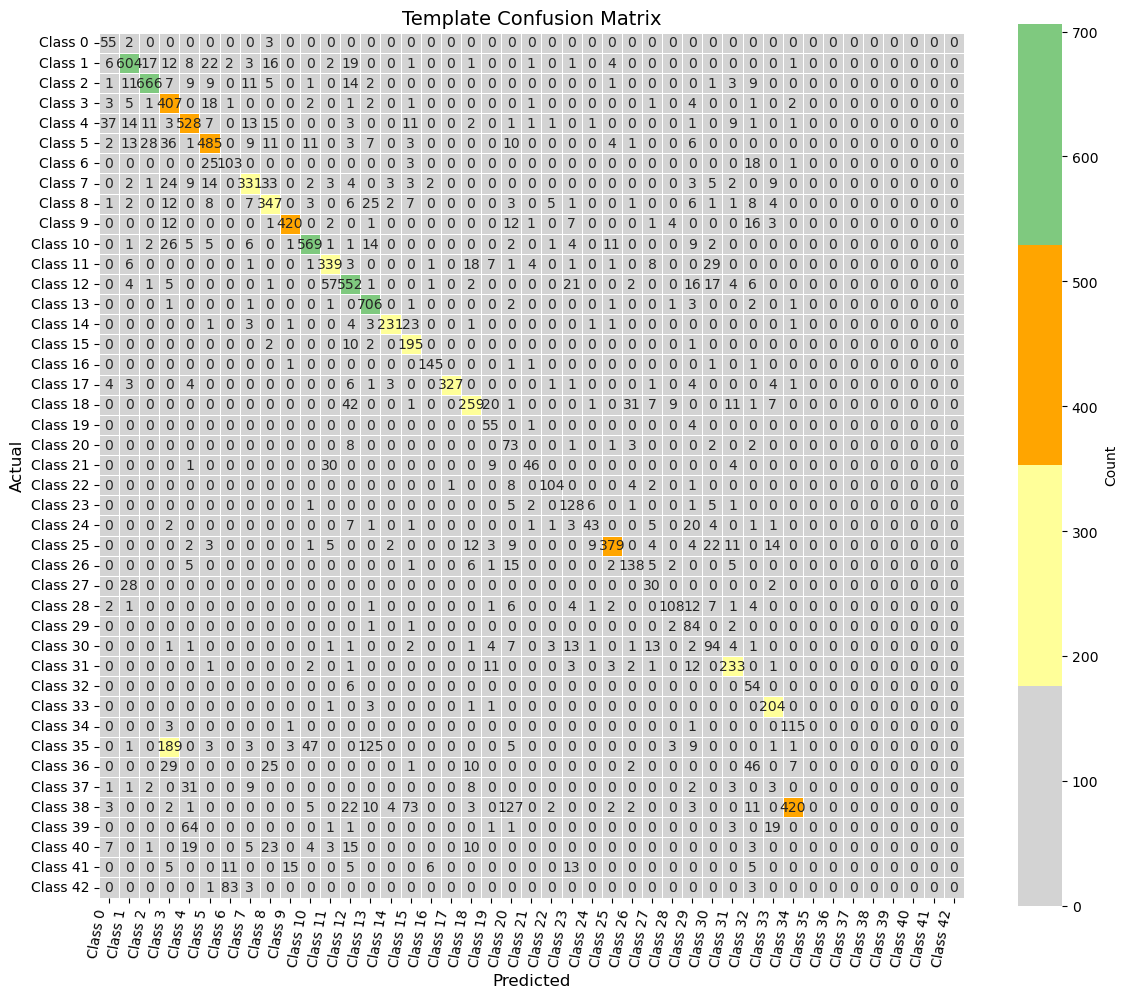

In [25]:
plot_confusion_matrix('Template', y_test, y_prediction)

In [26]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_prediction, average='weighted')
print('Model Precision:', precision)
print('Model Recall:', recall)
print('Model F-1 score:', fscore)
modelo.append(precision)
modelo.append(recall)
modelo.append(fscore)
modelo.append(format_time(time_callback.model_fit_time))

modelos.append(modelo)

Model Precision: 0.6807543800870032
Model Recall: 0.7250197941409343
Model F-1 score: 0.6924388735768467


<HR>

### HUE Features

In [27]:
# Derive HUE dataset

features_hue = features['Hue_Hist'].to_numpy()
features_hue = np.stack(features_hue)

if use_split_test is True:
    # split the data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(features_hue, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)
else:
    X_train = features['Hue_Hist'].to_numpy()
    X_train = np.stack(X_train)
    y_train = features['ClassId'].to_numpy()

    X_test = test_features['Hue_Hist'].to_numpy()
    X_test = np.stack(X_test)
    y_test = test_features['ClassId'].to_numpy()


In [28]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (8600, 180)
y_train.shape: (8600,)
X_test.shape: (12630, 180)
y_test.shape: (12630,)


In [29]:
num_features = X_train.shape[1]
learningRate = 0.01
model = build_model(num_features, learningRate)
# print(model.summary())

time_callback = TimeHistory()
history = model.fit(x=X_train, y=y_train, epochs=3000, verbose=0, validation_split=0.2, batch_size=32,
                    callbacks=[time_callback])

print('Overall elapsed time:', time_callback.model_fit_time)

# Log metrics
modelo = ['HUE']
modelo.append(history)


Overall elapsed time: 2317.4364540576935


In [30]:
# Make predictions on test data using Template Matching Features
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# results = model.evaluate(X_test, y_test, batch_size=32)
# print("test loss, test acc:", results)

test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=32)
print("test loss, test acc:", test_loss)

test_rmse = np.sqrt(test_loss)
print('Test rmse:', test_rmse)


# Predict
y_pred = model.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

Evaluate on test data
test loss, test acc: [699.8994750976562, 0.10752177238464355]
Test rmse: [26.4556133   0.32790513]
395/395 [==============================] - 0s 613us/step

Accuracy on Test Set: 10.75217735550277


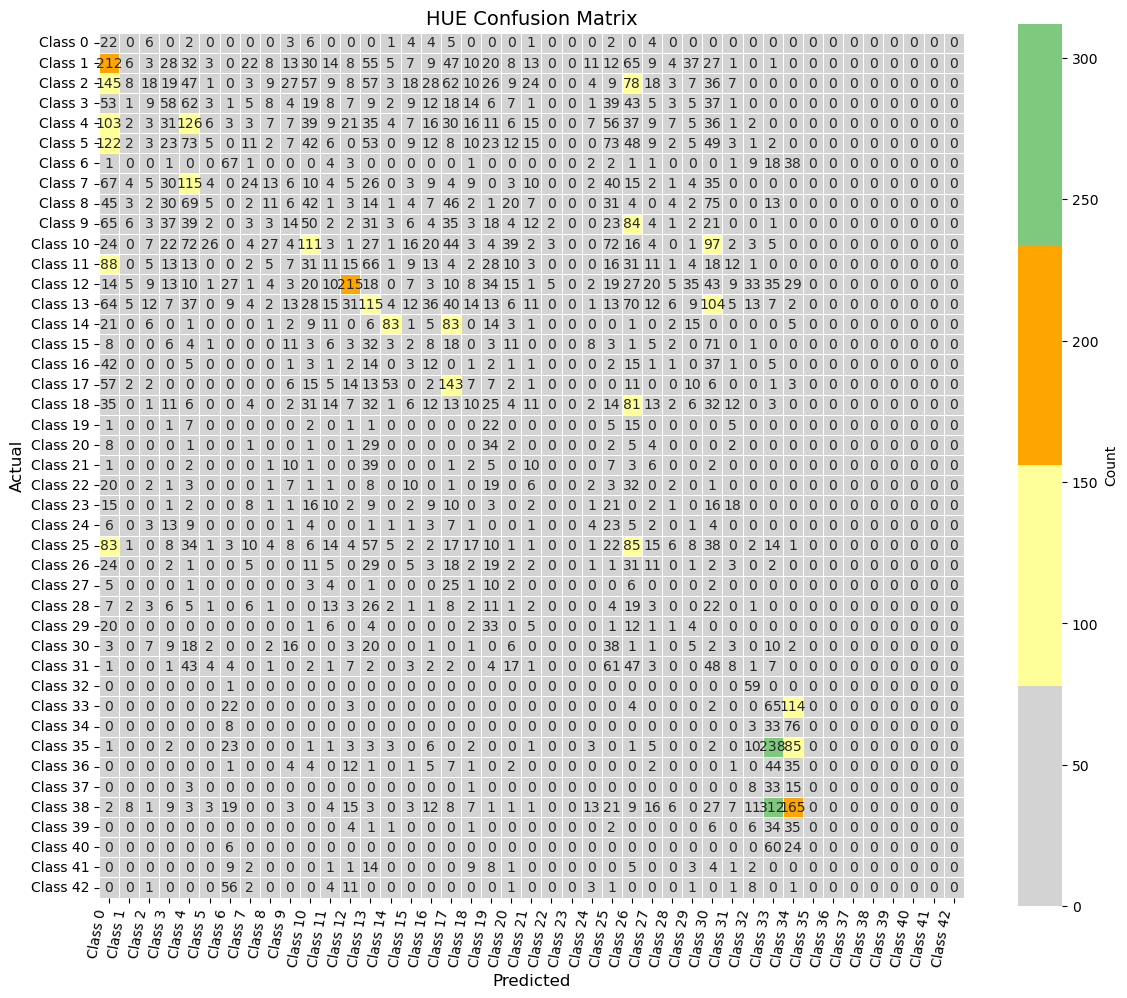

In [31]:
plot_confusion_matrix('HUE', y_test, y_prediction)

In [32]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_prediction, average='weighted')
print('Model Precision:', precision)
print('Model Recall:', recall)
print('Model F-1 score:', fscore)
modelo.append(precision)
modelo.append(recall)
modelo.append(fscore)
modelo.append(format_time(time_callback.model_fit_time))

modelos.append(modelo)

Model Precision: 0.1238195669512265
Model Recall: 0.1075217735550277
Model F-1 score: 0.0964910339713046


<HR>

### Saturation Features

In [33]:
# Derive Saturation dataset

features_sat = features['Saturation_Hist'].to_numpy()
features_sat = np.stack(features_sat)

if use_split_test is True:
    # split the data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(features_sat, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)
else:
    X_train = features['Saturation_Hist'].to_numpy()
    X_train = np.stack(X_train)
    y_train = features['ClassId'].to_numpy()

    X_test = test_features['Saturation_Hist'].to_numpy()
    X_test = np.stack(X_test)
    y_test = test_features['ClassId'].to_numpy()


In [34]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (8600, 256)
y_train.shape: (8600,)
X_test.shape: (12630, 256)
y_test.shape: (12630,)


In [35]:
num_features = X_train.shape[1]
learningRate = 0.01
model = build_model(num_features, learningRate)
# print(model.summary())

time_callback = TimeHistory()
history = model.fit(x=X_train, y=y_train, epochs=1000, verbose=0, validation_split=0.2, batch_size=32,
                    callbacks=[time_callback])

print('Overall elapsed time:', time_callback.model_fit_time)

# Log metrics
modelo = ['SAT']
modelo.append(history)


Overall elapsed time: 1422.8218307495117


In [36]:
# Make predictions on test data using Template Matching Features
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# results = model.evaluate(X_test, y_test, batch_size=32)
# print("test loss, test acc:", results)

test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=32)
print("test loss, test acc:", test_loss)

test_rmse = np.sqrt(test_loss)
print('Test rmse:', test_rmse)


# Predict
y_pred = model.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

Evaluate on test data
test loss, test acc: [288.3316650390625, 0.06373713165521622]
Test rmse: [16.98033171  0.25246214]
395/395 [==============================] - 0s 772us/step

Accuracy on Test Set: 6.373713380839272


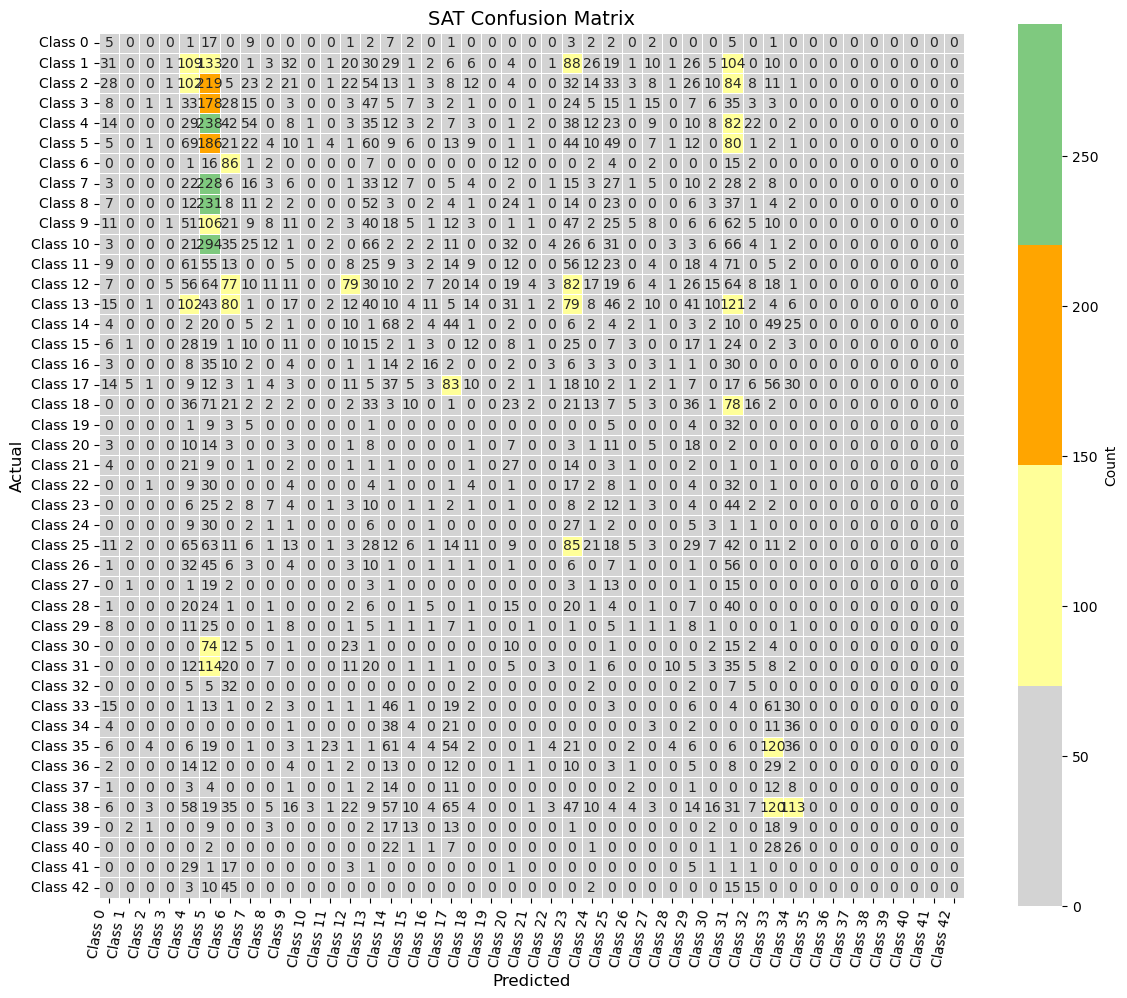

In [37]:
plot_confusion_matrix('SAT', y_test, y_prediction)

In [38]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_prediction, average='weighted')
print('Model Precision:', precision)
print('Model Recall:', recall)
print('Model F-1 score:', fscore)
modelo.append(precision)
modelo.append(recall)
modelo.append(fscore)
modelo.append(format_time(time_callback.model_fit_time))

modelos.append(modelo)

Model Precision: 0.05113561751555312
Model Recall: 0.06373713380839272
Model F-1 score: 0.04410028446022089


<HR>

### RESNET Features

In [39]:
# Derive RESNET101 dataset

features_res = features['RESNET101'].to_numpy()
features_res = np.stack(features_res)

if use_split_test is True:
    # split the data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(features_res, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)
else:
    X_train = features['RESNET101'].to_numpy()
    X_train = np.stack(X_train)
    y_train = features['ClassId'].to_numpy()

    X_test = test_features['RESNET101'].to_numpy()
    X_test = np.stack(X_test)
    y_test = test_features['ClassId'].to_numpy()


In [40]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (8600, 2048)
y_train.shape: (8600,)
X_test.shape: (12630, 2048)
y_test.shape: (12630,)


In [41]:
num_features = X_train.shape[1]
learningRate = 0.01
model = build_model(num_features, learningRate)
# print(model.summary())

time_callback = TimeHistory()
history = model.fit(x=X_train, y=y_train, epochs=3000, verbose=0, validation_split=0.2, batch_size=32,
                    callbacks=[time_callback])

print('Overall elapsed time:', time_callback.model_fit_time)

# Log metrics
modelo = ['ResNet101']
modelo.append(history)


Overall elapsed time: 2610.4978108406067


In [42]:
# Make predictions on test data using Template Matching Features
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# results = model.evaluate(X_test, y_test, batch_size=32)
# print("test loss, test acc:", results)

test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=32)
print("test loss, test acc:", test_loss)

test_rmse = np.sqrt(test_loss)
print('Test rmse:', test_rmse)


# Predict
y_pred = model.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

Evaluate on test data
test loss, test acc: [3.5383005142211914, 0.473475843667984]
Test rmse: [1.88103708 0.68809581]
395/395 [==============================] - 1s 2ms/step

Accuracy on Test Set: 47.347585114806016


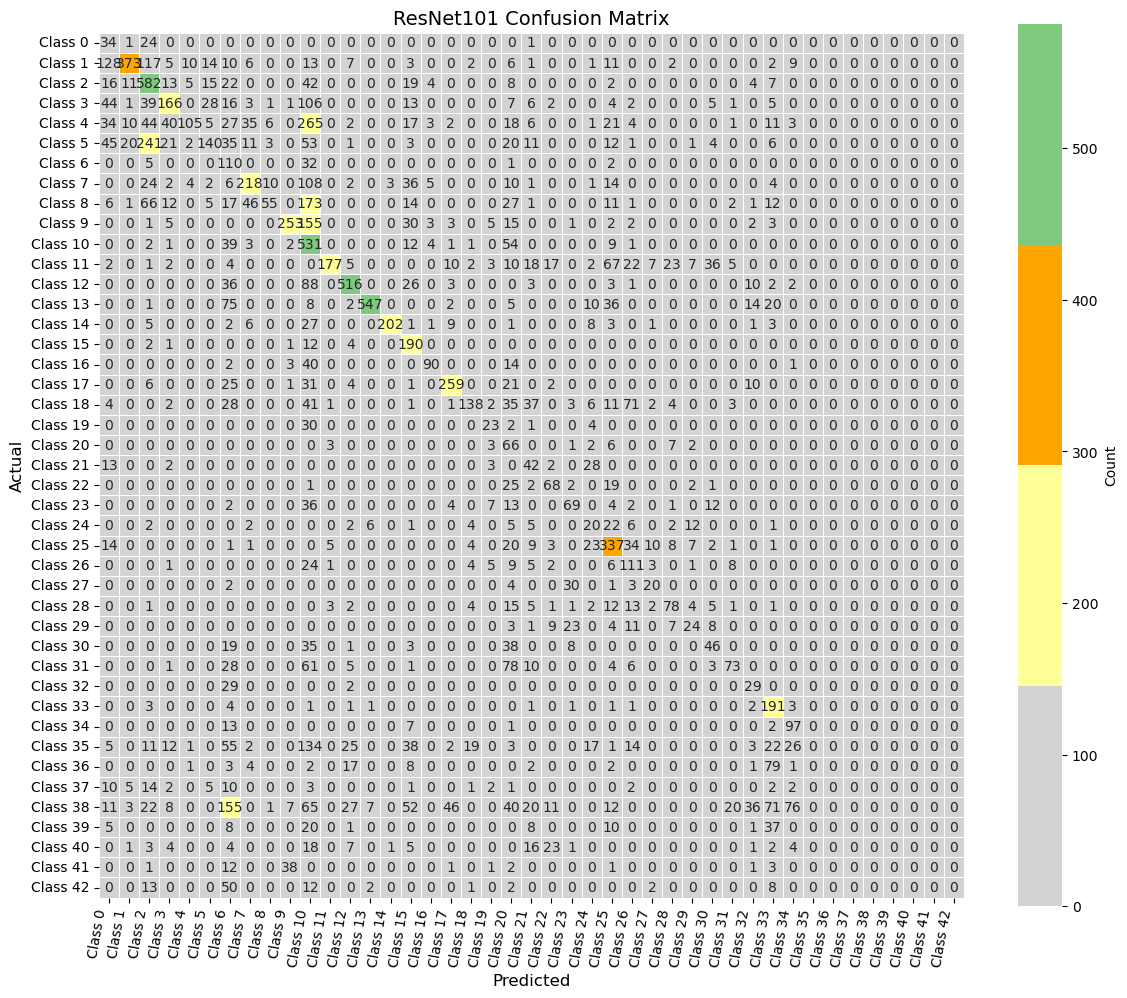

In [43]:
plot_confusion_matrix('ResNet101', y_test, y_prediction)

In [44]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_prediction, average='weighted')
print('Model Precision:', precision)
print('Model Recall:', recall)
print('Model F-1 score:', fscore)
modelo.append(precision)
modelo.append(recall)
modelo.append(fscore)
modelo.append(format_time(time_callback.model_fit_time))

modelos.append(modelo)

Model Precision: 0.5639432768326917
Model Recall: 0.4734758511480602
Model F-1 score: 0.4599784618112102


<HR>

### VGG16 Features

In [45]:
# Derive VGG16 dataset

features_vgg = features['VGG16'].to_numpy()
features_vgg = np.stack(features_vgg)

if use_split_test is True:
    # split the data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(features_vgg, features['ClassId'].to_numpy(), test_size=0.2, random_state=42)
else:
    X_train = features['VGG16'].to_numpy()
    X_train = np.stack(X_train)
    y_train = features['ClassId'].to_numpy()

    X_test = test_features['VGG16'].to_numpy()
    X_test = np.stack(X_test)
    y_test = test_features['ClassId'].to_numpy()


In [46]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (8600, 512)
y_train.shape: (8600,)
X_test.shape: (12630, 512)
y_test.shape: (12630,)


In [47]:
num_features = X_train.shape[1]
learningRate = 0.01
model = build_model(num_features, learningRate)
# print(model.summary())

time_callback = TimeHistory()
history = model.fit(x=X_train, y=y_train, epochs=2000, verbose=0, validation_split=0.2, batch_size=32,
                    callbacks=[time_callback])

print('Overall elapsed time:', time_callback.model_fit_time)

# Log metrics
modelo = ['VGG16']
modelo.append(history)


Overall elapsed time: 3549.1314392089844


In [48]:
# Make predictions on test data using Template Matching Features
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# results = model.evaluate(X_test, y_test, batch_size=32)
# print("test loss, test acc:", results)

test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=32)
print("test loss, test acc:", test_loss)

test_rmse = np.sqrt(test_loss)
print('Test rmse:', test_rmse)


# Predict
y_pred = model.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

Evaluate on test data
test loss, test acc: [4.971492290496826, 0.03871734067797661]
Test rmse: [2.22968435 0.19676722]
395/395 [==============================] - 0s 664us/step

Accuracy on Test Set: 3.8717339667458432


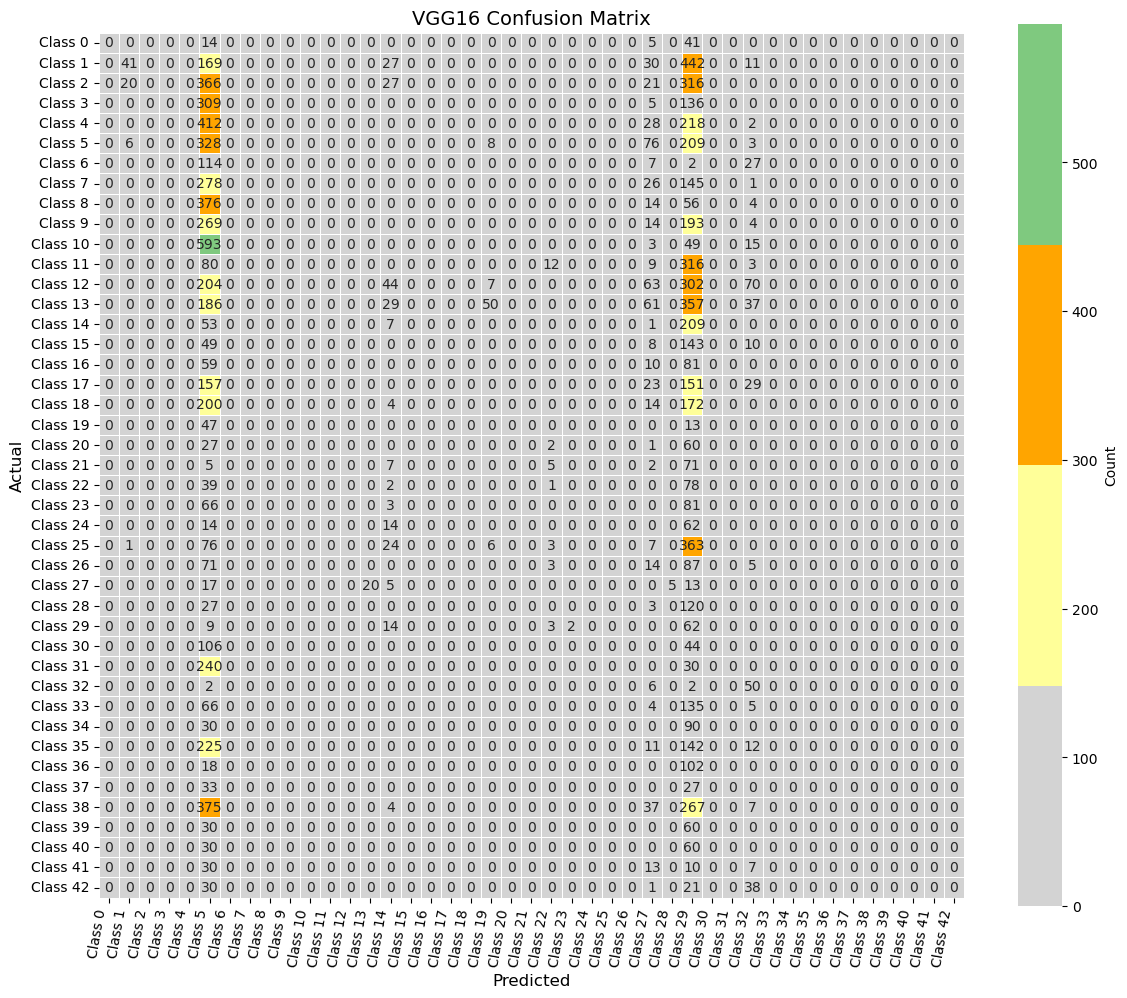

In [49]:
plot_confusion_matrix('VGG16', y_test, y_prediction)

In [50]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_prediction, average='weighted')
print('Model Precision:', precision)
print('Model Recall:', recall)
print('Model F-1 score:', fscore)
modelo.append(precision)
modelo.append(recall)
modelo.append(fscore)
modelo.append(format_time(time_callback.model_fit_time))

modelos.append(modelo)

Model Precision: 0.03899401203295256
Model Recall: 0.03871733966745843
Model F-1 score: 0.013092739780720477


<HR>

### Model Accuracy Comparison

In [51]:
print('Model Accuracy on Test Data\n')
print('   Model         Precision', '\t', 'Recall\t\tF1-Score \tEfficiency')
print('=========================================================================')
for modelo in modelos:
    tab  = '\t\t' if (modelo[0]!='Template' and modelo[0]!='ResNet101') else '\t'
    tab2  = '\t' if (modelo[0]=='ResNet101') else '\t'
    print(modelo[0], tab, f'{modelo[2]:.6f}', '\t', f'{modelo[3]:.6f}', tab2, f'{modelo[4]:.6f}', tab2, f'{modelo[5]}')
                                                                               

Model Accuracy on Test Data

   Model         Precision 	 Recall		F1-Score 	Efficiency
HOG 		 0.750167 	 0.803800 	 0.769758 	 0:01:06
Template 	 0.680754 	 0.725020 	 0.692439 	 1:20:14
HUE 		 0.123820 	 0.107522 	 0.096491 	 0:38:37
SAT 		 0.051136 	 0.063737 	 0.044100 	 0:23:42
ResNet101 	 0.563943 	 0.473476 	 0.459978 	 0:43:30
VGG16 		 0.038994 	 0.038717 	 0.013093 	 0:59:09


<HR>

### Eval model with test data

In [52]:
testcols = ['HOG_Features','Template_Pattern', 'Hue_Hist', 'Saturation_Hist', 'RESNET101', 'VGG16']
pruebas = []


In [53]:
# Use Template dataset

for i in range(6):
    feature_name = testcols[i]

    X_test = test_features[feature_name].to_numpy()
    X_test = np.stack(X_test)
    y_test = test_features['ClassId'].to_numpy()
    
    print('Evaluate on test datafor model ' + feature_name)
    print("-------------------------------------------------------------")
    print('Shape of test data:', X_test.shape)

    model = modelos[i][1].model


    tiempo = time.time()
    test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=32)
    tiempo = time.time() - tiempo

    # Predict
    y_pred = model.predict(X_test)

    print("test loss, test acc:", test_loss)
    test_rmse = np.sqrt(test_loss)
    print('Test rmse:', test_rmse)

    y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
    row = 0
    for p in y_pred:
        clase = np.argmax(p)
        y_prediction[row] = clase
        row+=1

    accuracy = accuracy_score(y_test, y_prediction)
    print("\nAccuracy on Test Set:", accuracy*100)
    
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_prediction, average='weighted')
    print(f'Model Precision: {precision:.6f}')
    print(f'Model Recall: {recall:.6f}')
    print(f'Model F-1 score: {fscore:.6f}')
    print(f'Efficiency: {format_time(tiempo, True)}')
    print('='*50, '\n')
    pruebas.append([modelos[i][0], precision, recall, fscore, format_time(tiempo, True)])


Evaluate on test datafor model HOG_Features
-------------------------------------------------------------
Shape of test data: (12630, 2916)
395/395 [==============================] - 0s 754us/step
test loss, test acc: [1.7343155145645142, 0.8038004636764526]
Test rmse: [1.31693413 0.8965492 ]

Accuracy on Test Set: 80.38004750593825
Model Precision: 0.750167
Model Recall: 0.803800
Model F-1 score: 0.769758
Efficiency: 0.394929

Evaluate on test datafor model Template_Pattern
-------------------------------------------------------------
Shape of test data: (12630, 3483)
395/395 [==============================] - 0s 778us/step
test loss, test acc: [3.0604491233825684, 0.7250198125839233]
Test rmse: [1.74941394 0.85148095]

Accuracy on Test Set: 72.50197941409343
Model Precision: 0.680754
Model Recall: 0.725020
Model F-1 score: 0.692439
Efficiency: 0.388745

Evaluate on test datafor model Hue_Hist
-------------------------------------------------------------
Shape of test data: (12630, 18

In [54]:
print('Model Accuracy on Test Data\n')
print('   Model         Precision', '\t', 'Recall\t\tF1-Score \tEfficiency')
print('=========================================================================')
for modelo in pruebas:
    tab  = '\t\t' if (modelo[0]!='Template' and modelo[0]!='ResNet101') else '\t'
    tab2  = '\t' if (modelo[0]=='ResNet101') else '\t'
    print(modelo[0], tab, f'{modelo[1]:.6f}', '\t', f'{modelo[2]:.6f}', tab2, f'{modelo[3]:.6f}', tab2, f'{modelo[4]}')
                                                                               

Model Accuracy on Test Data

   Model         Precision 	 Recall		F1-Score 	Efficiency
HOG 		 0.750167 	 0.803800 	 0.769758 	 0.394929
Template 	 0.680754 	 0.725020 	 0.692439 	 0.388745
HUE 		 0.123820 	 0.107522 	 0.096491 	 0.318262
SAT 		 0.051136 	 0.063737 	 0.044100 	 0.312819
ResNet101 	 0.563943 	 0.473476 	 0.459978 	 0.463432
VGG16 		 0.038994 	 0.038717 	 0.013093 	 0.340077


<HR>